# Exploratory Analysis 

In this notebook we will analyze the datasets to get an overview before we start modelling. In addition, we will also create a smaller version of the dataset so that we can run some experiments on a CPU in a reasonable amount of time. 

The notebook is structured as follows: 
 + **Dataset Overview and Profiling**
     - Item Info
     - User Info
     - User-Item Interaction
 + **User Item Interaction Deep Dive**
     - Join with item metadata
 + **Exploration of possible KPIs:** What business metrics might be worth measuring and tracking to understand the impact of a recommender? 
 + **Cold Start:** How many new items and/or users do we see
 + **User Deep Dive:** Let's look at some individual users to get a better understanding of the customer journey
 + **Seasonality:** How do sold items change over the course of a year?
 + **Create Datasets:** Generate data for training. 

<div class="alert alert-block alert-info">
<b>NOTE:</b> If you're just interested in TF recommenders you can skip this notebook. This notebook is only useful to gain some context on the datasets we will use for training. 
</div>


## **Imports**

In [71]:
import random

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_data_validation as tfdv
from matplotlib import pyplot as plt

# **Dataset Overview and Profiling** 

In this section we will go through each of the individual datasets and [profile](https://en.wikipedia.org/wiki/Data_profiling) them. There are a lot of tools we could use for this purpose, including a simple [`pd.DataFrame.describe()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) or [pandas-profiling](https://github.com/pandas-profiling/pandas-profiling) since the datasets are pretty small and we will be using pandas. However, given that these walk-throughs were created for a **TensorFlow** User Group, let's use [TensorFlow Data Validation (TFDV)](https://www.tensorflow.org/tfx/data_validation/get_started). 

Although TFDV can be a bit unwieldy with a lot of knobs to tune, one significant advantage to this tool is that it can be used both for in-memory DataFrames as well as large datasets in cloud storage. We will just use all of the default settings for now since the purpose is just to get a general understanding of the datasets and not explore the capabilities of TFDV in-depth (we can leave that for another meetup session ;))

## **Item Info**

Let's start with the items. This dataset contains some metadata about all of the retail items.

In [2]:
item_info_df = pd.read_csv('item_info.csv', dtype={'item_no': str})

In [3]:
display(item_info_df.head())

item_no colour gender_description          brand  \
0   206890150141030846  beige             unisex  bloomingville   
1  7637494654837559066   pink              girls   petit bateau   
2  7969520735315050609  beige             unisex    bobo choses   
3  -565751122846696741  white             unisex    piupiuchick   
4  6688930722259797984  green             unisex      filibabba   

          product_group  min_age  max_age  
0             furniture      NaN      NaN  
1         clothing sets    0.125      2.0  
2  jumpers and knitwear    1.000     11.0  
3                  tops    1.000     14.0  
4          baby feeding      NaN      NaN

<div class="alert alert-block alert-info">
<b>Tip:</b> If you don't see any output from the following cell, try running it again. Sometimes TFDV acts up a bit when trying to visualize statistics in a notebook.  
</div>


In [4]:
item_info_statistics = tfdv.generate_statistics_from_dataframe(item_info_df )
tfdv.visualize_statistics(item_info_statistics)

**Takeaway:** While the age columns are quite interesting and would probably be very useful for creating personalized recommendations, these features are missing for about 20% of the data. In the interest of keeping things simple, let's limit ourselves to just considering `gender_description`, `brand`, and `product_group` for now as additional features (in addition to the `item_no` itself). 
    
Note that there are about 600 unique brands and 100 unique product groups in the dataset, with both having quite a long tail. 
    
    
There are ~**60,000** unique items in the dataset

## **User Info**

This dataset contains some metadata about the users. 

In [5]:
user_info_df = pd.read_csv('user_info.csv', dtype={'user_no': str})

In [7]:
display(user_info_df.head())

user_no country    aov  avg_markdown
0   8587933979694308845  sweden  479.2     -0.200000
1   2740387653650048572  sweden  837.6     -0.200000
2   2084988796719274722  sweden  942.4     -0.560000
3  -4662401680846085311  sweden  438.4     -0.620000
4  -1086148156436227367  sweden  664.8     -0.286667

In [8]:
user_info_statistics = tfdv.generate_statistics_from_dataframe(user_info_df)
tfdv.visualize_statistics(user_info_statistics)

**Takeaway:** `aov` (average order value) and `avg_markdown` might be useful features while we can definitely drop `country` since we only have swedish customers in this dataset. 
    
There are ~**25,000** unique customers in the dataset. 

## **User Item Interactions**

This is the event log showing user-item interactions. For a simple matrix-factorization collaborative filtering model, this is the only dataset we would need. 

In [9]:
user_item_interaction_df = pd.read_csv('user_item_interactions.csv', dtype={'user_no': str, 'item_no': str})

In [10]:
display(user_item_interaction_df.head())

user_no               item_no        date  eventtype
0  9060639138425951676   -478270421339298398  2021-06-24  purchased
1  9060639138425951676   2658388892627023500  2021-11-27   pageView
2  9060639138425951676    504233002877562247  2021-11-26   pageView
3  9060639138425951676  -3413566329152665076  2021-10-21   pageView
4  9060639138425951676   6700254580945881296  2021-10-10   pageView

In [13]:
interaction_statistics = tfdv.generate_statistics_from_dataframe(user_item_interaction_df)
tfdv.visualize_statistics(interaction_statistics)

In [12]:
print(user_item_interaction_df['date'].min())
print(user_item_interaction_df['date'].max())

2021-01-01
2021-11-30


**Takeaway:** We have roughly one year's worth of data to work with, and there are \~**1,000,000** interactions in this dataset. There are many more unique users in this dataset compared to the user-only dataset (~90k vs. ~25k).
    
Note that we have 4 unique event types. This provides interesting possibilities for how we choose to frame the problem. For example, we could train a **retrieval** model meant to get candidate items from the complete catalogue which may interest the customer. For such a model, we might say that *any* interaction (even just a `pageView` event) between a user and an item indicates some degree of interest and we should therefore treat every interaction as a "positive" example.
    
We could also train a **ranking** model meant to predict *how much* a user is interested in an item. For such a model, we might want to differentiate between the different interactions. How we choose to do this is highly subjective. 
    
Finally, we could train two separate models for a two-stage recommendation process in which the first model is meant to retrieve candidate items that are then scored by the second model to surface the most relevant items to the user. 

---
## **Tasks**

 - [x] Get poetry working and add TFDV
 - [x] Profile each dataset
 - [x] User/item interactions details 
     - [x] How many page views are turned into purchases? 
     - [x] How many wishlist are turned into purchases
     - [x] Items per basket (big buyers?)
 - [x] Join together 
     - [x] Popular item types? Popular colors? Popular brands? 
 - [x] KPIs 
     - [x] Visitors per month
     - [x] Conversion ratio
     - [x] Total items sold (per month)
     - [x] Sessions per month
     - [x] Sessions with a purchase per month
     - [x] Returned users 
 - [x] Individual User Journey 
     - [x] Dashboard
     - [x] Buy same type of clothes? 
     - [x] Can we see them growing up?  
     - [x] Same brand, same gender?
 - [x] Cold start, new users/items
 - [ ] Train/test split and baseline
 - [ ] Determination of features
 - [ ] Write out data for training
 - [ ] Clean up and write text (summarize)
     - [ ] How many unique items/users
     - [ ] Most popular items, most frequent users
     - [ ] Event types
 
<div class="alert alert-block alert-info">
<b>Tip:</b> Use blue boxes (alert-info) for tips and notes. 
If it’s a note, you don’t have to include the word “Note”.
</div>

<div class="alert alert-block alert-success">
<b>Up to you:</b> Use green boxes sparingly, and only for some specific 
purpose that the other boxes can't cover. For example, if you have a lot 
of related content to link to, maybe you decide to use green boxes for 
related links from each section of a notebook.
</div>

<div class="alert alert-block alert-danger">
<b>Just don't:</b> In general, avoid the red boxes. These should only be
used for actions that might cause data loss or another major issue.
</div>

<div class="alert alert-block alert-warning">
<b>Example:</b> Use yellow boxes for examples that are not 
inside code cells, or use for mathematical formulas if needed.
    
```python
class Dev:
    def __init__(self):
```
</div>

$Hello_p$

---
---
# **User-Item Interaction Deep Dive**

In this section we will look more at the user-item interaction data since this will be the most important dataset for training our recommendation models.

If a user interacts with an item multiple times (or views it, then puts it in the cart, etc.) there will be multiple entries for that user-item pair. In order to make the data a bit easier to work with, let's pivot it so that we can look at the data on a user-item level, rather than an event level. 

In [21]:
pivoted = pd.pivot_table(user_item_interaction_df, 
                         index=['user_no', 'item_no'], 
                         columns=['eventtype'], 
                         aggfunc='count', 
                         fill_value=0).reset_index()

pivoted.columns = ['user_no', 'item_no', 'addToCart', 'addToWishlist', 'pageView', 'purchased']

In [22]:
display(pivoted)

user_no               item_no  addToCart  addToWishlist  \
0       -1000173980966705625   2356442837089120035          0              0   
1       -1000173980966705625   6194820387173010563          0              0   
2       -1000173980966705625   6283078728673886163          0              0   
3       -1000190704253701773    383205862898605182          1              0   
4       -1001470904269092144  -4036395326208857801          2              0   
...                      ...                   ...        ...            ...   
784712      9999165590351299  -7779279685545513760          0              0   
784713      9999165590351299    169913927963481109          0              0   
784714      9999165590351299   3042466209036108905          0              0   
784715     99995943117292705  -8708142935431931645          0              0   
784716     99995943117292705   5311498798413225065          0              0   

        pageView  purchased  
0              1          1  
1              1          0  
2              1          1  
3              1          0  
4              2          0  
...          ...        ...  
784712         1          0  
784713         1          0  
784714         1          0  
784715         0          1  
784716         1          0  

[784717 rows x 6 columns]

<div class="alert alert-block alert-info">
Now we only have ~785,000 user-item interactions instead of ~1M events!
</div>

Let's take a closer look at all of the purchses. In particular, what we'd like to know is if all purchases are preceded by other events such as `addToCart` or `pageView`. We'd expect that a user needs to view an item before it is bought, but let's make sure this is the case. 

In [23]:
purchased = pivoted.loc[pivoted['purchased'] == 1]

purchased_no_other_events = purchased.loc[(purchased['addToCart'] == 0) & 
                                          (purchased['addToWishlist'] == 0) & 
                                          (purchased['pageView'] == 0)]

In [24]:
print(f"{len(purchased_no_other_events) / len(purchased):.2%} of purchases had no other events")

58.22% of purchases had no other events


<div class="alert alert-block alert-warning">
<b>Warning:</b> Many purchases have no other events, which has implications for how we track conversions. For example, just because few pageViews turn into purchases isn't necessarily bad if this is not the typical "path" of a customer. 
</div>

Let's take the opposite view and look at the percentage of **pageView, addToCard, addToWishlist** event types which turned into a purchase. 

In [24]:
def calc_percent_conversion(df, event):
    event_df = df.loc[df[event] > 0]
    purchases_after_event = event_df.loc[event_df['purchased'] > 0]
    return len(purchases_after_event) / len(event_df)

def print_conversion(df, event):
    conversion_ratio = calc_percent_conversion(df, event)
    print(f"{conversion_ratio:<10.2%} {event:<15} events resulted in a purchase")

In [25]:
print_conversion(pivoted, 'addToCart')
print_conversion(pivoted, 'addToWishlist')
print_conversion(pivoted, 'pageView')

22.29%     addToCart       events resulted in a purchase
8.37%      addToWishlist   events resulted in a purchase
12.74%     pageView        events resulted in a purchase


At first these numbers might seem a bit alarming (>75\% of items added to a cart aren't actually purchased!?), but given the findings above it makes sense. 

Regardless, the above could be an example of a business metric that we track to assess the performance of our recommendation model ("how page view events result in a purchase?" If the number is very low perhaps we are surfacing a lot of items that aren't actually relevant for customers)

---

### **Items per basket**

Let's now look at the data on a session level (where we assume that any events on the same data are in the same "session" for simplicity). We want to know how many items users typically bought at a time. 

In [26]:
purchases = user_item_interaction_df.loc[user_item_interaction_df['eventtype'] == 'purchased']
session_baskets = purchases.groupby(['user_no', 'date']).agg('count').reset_index()[['user_no', 'date', 'item_no']]

In [27]:
session_baskets.describe()

item_no
count  85452.000000
mean       2.658393
std        2.190587
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       20.000000

<div class="alert alert-block alert-info">
<b>More than 50% of the time users buy more than one item!</b>
    
This being the case, it would seem that we could get a lot of value from <b>item-item recommenders</b> ("more like this") or <b>association rule mining</b> ("frequently bought together with").
</div>

---

## **Join with Item Metadata**

Let's join the interaction data with the item metadata. This will allow us to answer questions such as, 
 - What are the popular item types? 
 - What are some of the popular brands? 
 
These types of insights may be helpful when creating more complex models with additional features about the items. 

In [31]:
user_item_interaction_w_metadata = pd.merge(pivoted, 
                                            item_info_df,
                                            how='left', 
                                            on='item_no')

In [32]:
user_item_interaction_w_metadata

user_no               item_no  addToCart  addToWishlist  \
0       -1000173980966705625   2356442837089120035          0              0   
1       -1000173980966705625   6194820387173010563          0              0   
2       -1000173980966705625   6283078728673886163          0              0   
3       -1000190704253701773    383205862898605182          1              0   
4       -1001470904269092144  -4036395326208857801          2              0   
...                      ...                   ...        ...            ...   
784712      9999165590351299  -7779279685545513760          0              0   
784713      9999165590351299    169913927963481109          0              0   
784714      9999165590351299   3042466209036108905          0              0   
784715     99995943117292705  -8708142935431931645          0              0   
784716     99995943117292705   5311498798413225065          0              0   

        pageView  purchased       colour gender_description         brand  \
0              1          1        white             unisex      aeromoov   
1              1          0         grey             unisex      aeromoov   
2              1          1        beige             unisex      aeromoov   
3              1          0        black             unisex   i dig denim   
4              2          0         navy              girls  ralph lauren   
...          ...        ...          ...                ...           ...   
784712         1          0  multi color             unisex       my home   
784713         1          0        black             unisex         reima   
784714         1          0        green             unisex         stiga   
784715         0          1         blue               boys         reima   
784716         1          0        brown             unisex         reima   

                product_group  min_age  max_age  
0                     bedding      NaN      NaN  
1                   furniture      NaN      NaN  
2                   furniture      NaN      NaN  
3       fleeces and midlayers      1.0     12.0  
4        jumpers and knitwear      1.0     14.0  
...                       ...      ...      ...  
784712              role play      NaN      NaN  
784713               trainers      4.0     14.0  
784714           outdoor play      4.0     10.0  
784715              coveralls      1.0     10.0  
784716              coveralls      1.0     10.0  

[784717 rows x 12 columns]

Let's compare user-item interactions that ended in a purchase versus those that did not. 

One of the nice features of TFDV is that it can allow us to compare the statistics of two datasets. This can come handy for small pieces of analysis like this or for detecting data drift and training/serving skew. 

In [33]:
purchased = user_item_interaction_w_metadata.loc[user_item_interaction_w_metadata['purchased'] > 0]
not_purchased = user_item_interaction_w_metadata.loc[user_item_interaction_w_metadata['purchased'] == 0]

purchased_statistics = tfdv.generate_statistics_from_dataframe(purchased)
not_purchased_statistics = tfdv.generate_statistics_from_dataframe(not_purchased)

<div class="alert alert-block alert-info">
<b>Tip:</b> Click the box that says "percentages"
</div>

In [35]:
tfdv.visualize_statistics(purchased_statistics, 
                          not_purchased_statistics, 
                          lhs_name='purchased', 
                          rhs_name='not_purchased')

---

### **Items Analysis** 

Let's analyze the data on an item level. This may allow us to see certain patterns, such as whether particular brands or product groups have especially high/low conversion rates.  

In [40]:
item_purchases = pivoted.drop('user_no', axis=1).groupby('item_no').agg(np.sum)
user_interactions_with_item = pivoted['item_no'].value_counts()

item_summary = pd.merge(item_purchases,
                       user_interactions_with_item, 
                       left_index=True,
                       right_index=True).rename(columns={'item_no': 'user_interactions'})

item_summary['item_conversion'] = item_summary['purchased'] / item_summary['user_interactions']
item_summary = pd.merge(item_summary, item_info_df, how='left', left_index=True, right_on='item_no').reset_index(drop=True)

In [41]:
display(item_summary)

addToCart  addToWishlist  pageView  purchased  user_interactions  \
0              1              0         0          0                  1   
1              5              0         9          4                 16   
2              1              0         1          0                  2   
3              7              0         4          9                 19   
4              2              0         4          0                  4   
...          ...            ...       ...        ...                ...   
61698          4              0         0          0                  4   
61699          1              0        10          2                 13   
61700          4              0         3          1                  7   
61701          3              0        29          2                 30   
61702          0              0         0          1                  1   

       item_conversion               item_no colour gender_description  \
0             0.000000    -10001501373726678   pink             unisex   
1             0.250000  -1000182030290830232  black             unisex   
2             0.000000  -1000183384954605528   blue              girls   
3             0.473684  -1000321715684049686  green             unisex   
4             0.000000  -1000570342615087077   blue               boys   
...                ...                   ...    ...                ...   
61698         0.000000    999030474988862413    red               boys   
61699         0.153846    999032067904529387   pink              girls   
61700         0.142857    999084409713144028  black             unisex   
61701         0.066667    999328979874402204   grey             unisex   
61702         1.000000    999657375817052613   blue             unisex   

                       brand      product_group  min_age  max_age  
0               mini sibling        all in ones    0.125      3.0  
1                    by nils           trainers    5.000     14.0  
2      stella mccartney kids             skirts    1.000     14.0  
3                       joha            bottoms    0.125      4.0  
4                     minymo        all in ones    0.125      2.0  
...                      ...                ...      ...      ...  
61698      moschino kid-teen               tops    3.000     14.0  
61699                tretorn  coats and jackets    1.000     10.0  
61700         tommy hilfiger           headwear    3.000     14.0  
61701                ng baby            bedding      NaN      NaN  
61702                   msgm             shorts    5.000     14.0  

[61703 rows x 13 columns]

In [45]:
def sort_feature_by_conversion(df, feature, threshold=50):
    feature_summary = df.groupby(feature)['item_conversion'].describe()
    feature_summary = feature_summary.loc[feature_summary['count'] > threshold]
    return feature_summary.sort_values(by='mean', ascending=False)

In [46]:
sort_feature_by_conversion(item_summary, feature='brand', threshold=50)

count      mean       std  min       25%       50%       75%  \
brand                                                                         
petite olivia   70.0  0.520244  0.319332  0.0  0.308333  0.500000  0.750000   
falke           91.0  0.512633  0.362864  0.0  0.267857  0.500000  1.000000   
mam             61.0  0.465440  0.188679  0.0  0.379310  0.500000  0.588235   
play up        147.0  0.450867  0.393120  0.0  0.000000  0.500000  1.000000   
gobabygo        61.0  0.436541  0.302371  0.0  0.277778  0.454545  0.600000   
...              ...       ...       ...  ...       ...       ...       ...   
britax         182.0  0.106489  0.142994  0.0  0.000000  0.048810  0.189117   
cybex          287.0  0.105169  0.193594  0.0  0.000000  0.000000  0.156923   
nuna            53.0  0.101047  0.148931  0.0  0.000000  0.000000  0.166667   
silver cross    63.0  0.098609  0.219821  0.0  0.000000  0.000000  0.062500   
le toy van     127.0  0.095570  0.168361  0.0  0.000000  0.000000  0.142857   

                    max  
brand                    
petite olivia  1.000000  
falke          1.000000  
mam            0.857143  
play up        1.000000  
gobabygo       1.250000  
...                 ...  
britax         1.000000  
cybex          1.000000  
nuna           0.500000  
silver cross   1.000000  
le toy van     1.000000  

[242 rows x 8 columns]

In [47]:
sort_feature_by_conversion(item_summary, feature='product_group', threshold=50)

count      mean       std  min       25%  \
product_group                                                               
hair accessories                 575.0  0.439410  0.333335  0.0  0.045455   
shorts                          1145.0  0.401881  0.344386  0.0  0.000000   
underwear                       2204.0  0.387777  0.304713  0.0  0.142857   
baby feeding                     756.0  0.384390  0.271821  0.0  0.200000   
musical instruments and toys      81.0  0.379388  0.305663  0.0  0.200000   
...                                ...       ...       ...  ...       ...   
changing and travel bags         268.0  0.146670  0.193391  0.0  0.000000   
ride ons and walkers              60.0  0.139955  0.164393  0.0  0.000000   
car seats                        377.0  0.135372  0.166089  0.0  0.000000   
stroller parts and customisati   389.0  0.126250  0.210505  0.0  0.000000   
strollers                        442.0  0.065649  0.124919  0.0  0.000000   

                                     50%       75%   max  
product_group                                             
hair accessories                0.500000  0.666667  1.00  
shorts                          0.375000  0.600000  1.00  
underwear                       0.375000  0.571429  1.50  
baby feeding                    0.379310  0.552682  1.25  
musical instruments and toys    0.333333  0.500000  1.00  
...                                  ...       ...   ...  
changing and travel bags        0.000000  0.250000  1.00  
ride ons and walkers            0.045804  0.268234  0.50  
car seats                       0.097222  0.200000  1.00  
stroller parts and customisati  0.000000  0.222222  1.00  
strollers                       0.000000  0.095013  1.00  

[70 rows x 8 columns]

Some interesting results here that could warrant further investigation. There is a pretty wide spread of conversion rates between various brands and product groups. 

For example, we see that the over 50% of user interactions with the brand "petite olivia" end in a purchase, while less than 10% of interactions with "le toy van" end in a purchase. 

Similarly, over 40% of interactions with "hair accessories" end in a purchase while only 6.5% of interactions with "strollers" end in a purchase. 

---
---

# **Business Metrics** 

We've already looked a bit at some possible business metrics above (conversion rates for different event types). Here we can look at some other metrics that we might track to help us get a better understanding of how our business is doing, such as

 + Unique visitors per month
 + Purchases per month
 + User-item interactions ending in a purchase

One important thing to note is that while these types of metrics are ultimately much more important to the business than some offline machine learning metric like "Recall" or "Accuracy", it can be very difficult to isolate the effect of our recommendation system on these business metrics. This is where a robust A/B testing framework can be very useful so that we don't only evaluate our model on offline machine learning metrics that may or may not be correlated with the "actual" important metrics. 

**Unique Visitors per Month**

Let's track the number of unique visitors over time.

In [48]:
user_item_interaction_df['date'] = pd.to_datetime(user_item_interaction_df['date'])
interactions_by_month = user_item_interaction_df.groupby(user_item_interaction_df['date'].dt.month)
num_unique_visitors = [group[1]['user_no'].nunique() for group in interactions_by_month]

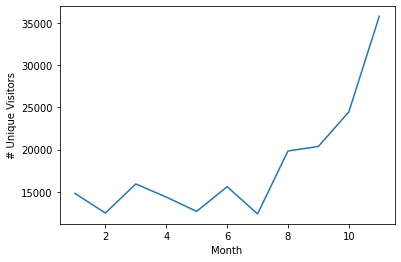

In [53]:
fig, ax = plt.subplots()
_ = ax.plot(range(1, len(num_unique_visitors) + 1),num_unique_visitors)
_ = ax.set_ylabel('# Unique Visitors')
_ = ax.set_xlabel('Month')

Quite a drastic increase in the number of unique visitors per month. Is this because the company is becoming more successful, or is it just a seasonal pattern with more unique visitors towards the end of the year because of back-to-school and colder weather? Hard to tell with only a year's worth of data..

**Purchases Per Month**

In [55]:
num_purchases = [len(group[1].loc[group[1]['eventtype'] == 'purchased']) for group in interactions_by_month]

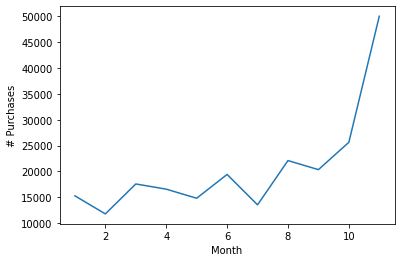

In [56]:
fig, ax = plt.subplots()
_ = ax.plot(range(1, len(num_purchases) + 1),num_purchases)
_ = ax.set_ylabel('# Purchases')
_ = ax.set_xlabel('Month')

The number of purchases per month follows a very similar pattern to the number of visitors per month. 

**User-item interactions that include a purchase**

In [57]:
total_user_item_interactions = [group[1].groupby(['user_no', 'item_no']).ngroups for group in interactions_by_month]
user_item_interactions_purchase = [group[1].loc[group[1]['eventtype'] == 'purchased'].groupby(['user_no', 'item_no']).ngroups
                                  for group in interactions_by_month]

conversion_by_month = np.array(user_item_interactions_purchase) / np.array(total_user_item_interactions)

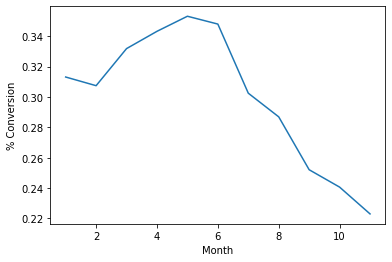

In [58]:
fig, ax = plt.subplots()
_ = ax.plot(range(1, len(conversion_by_month) + 1), conversion_by_month)
_ = ax.set_ylabel('% Conversion')
_ = ax.set_xlabel('Month')

Even though the volume of sales/unique users/etc. goes up, the conversion goes down. This may represent an opportunity to boost sales; if we can raise the conversion towards the end of the year it will translate into a big win given the large number of users we see during these months. 

---
---

# **Cold Start** 

A frequent issue in recommendation systems is the [cold start problem](https://en.wikipedia.org/wiki/Cold_start_(recommender_systems)). Cold start can be an especially big problem for collaborative filtering models (i.e. a model that relies solely on interaction history), since there may be many users or items for which there is no historical interaction data. 

Let's go through our data, and for each month find how many items/users are repeats (seen in previous months), and how many are new (never seen before). This could give us an idea of how big this problem is likely to be for us. 

To give a concrete example of the implications: imagine that every month nearly all of the site's visitors are completely new customers. This will have a profound effect for how we go about designing our recommendation system compared to a scenario in which nearly all of the site's visitors are repeat visitors. In the former scenario, we will know almost nothing about user's tastes and so may not even attempt any personalization (instead focusing on association rule mining or item-item recommendations), whereas in the latter scenario we can (hopefully) learn a lot of about what each user likes. 

In [59]:
user_set = set()
item_set = set()
num_new_users_by_month = []
num_new_items_by_month = []

num_repeat_users_by_month = []
num_repeat_items_by_month = []

for month, interaction_during_month in interactions_by_month:
    users_during_month = set(interaction_during_month['user_no'].unique())
    items_during_month = set(interaction_during_month['item_no'].unique())
    if month != 1: 
        new_users = users_during_month - user_set
        new_items = items_during_month - item_set
        repeat_users = users_during_month & user_set
        repeat_items = items_during_month & item_set
        
        num_new_users_by_month.append(len(new_users))
        num_new_items_by_month.append(len(new_items))
        num_repeat_users_by_month.append(len(repeat_users))
        num_repeat_items_by_month.append(len(repeat_items))

    user_set = user_set | users_during_month
    item_set = item_set | items_during_month

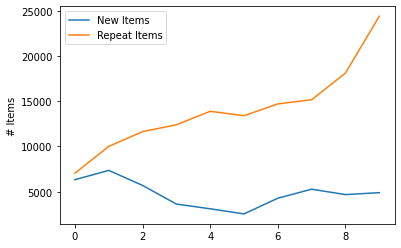

In [63]:
fig, ax = plt.subplots()
_ = ax.plot(num_new_items_by_month, label='New Items')
_ = ax.plot(num_repeat_items_by_month, label='Repeat Items')
_ = ax.set_ylabel('# Items')
_ = ax.legend()

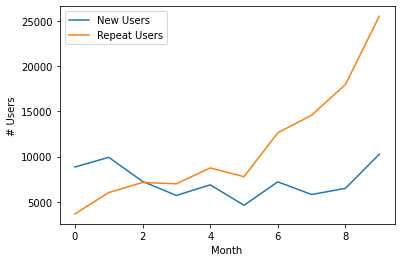

In [64]:
fig, ax = plt.subplots()
_ = ax.plot(num_new_users_by_month, label='New Users')
_ = ax.plot(num_repeat_users_by_month, label='Repeat Users')
_ = ax.set_ylabel('# Users')
_ = ax.set_xlabel('Month')
_ = ax.legend()

---
---

# **User Deep Dive**

In this section, we will try to get a better understanding of individual users. In particular we might ask questions such as, 

 + How many different items do users typically interact with? 
 + Are users very loyal to a particular brand?
 + Do users buy the same type of clothes?
 
It is often helpful to look at tons of examples to get a general idea of user behavior. This could help us model development by giving us an idea of what is important to a user. It can also be very helpful for model evaluation—are recommendations for a particular user consistent with their historical behavior? 

In [66]:
user_history_groups = user_item_interaction_w_metadata.groupby('user_no')

In [67]:
display(user_history_groups['item_no'].agg('count').describe())

count    87795.000000
mean         8.938060
std          6.336523
min          1.000000
25%          3.000000
50%          8.000000
75%         15.000000
max         20.000000
Name: item_no, dtype: float64

Most users have interacted with more than one item. 

In [68]:
user_history_groups['gender_description'].agg('nunique').describe()

count    87795.000000
mean         1.726123
std          0.751923
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: gender_description, dtype: float64

In [69]:
user_history_groups['brand'].agg('nunique').describe()

count    87795.000000
mean         4.686816
std          3.460774
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         20.000000
Name: brand, dtype: float64

In [70]:
user_history_groups['product_group'].agg('nunique').describe()

count    87795.000000
mean         4.565203
std          3.116017
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         18.000000
Name: product_group, dtype: float64

Below is a small helper function to display the history of a user. If no user is provided, a random user is selected and displayed. 

In [72]:
def display_user(df, user=None):
    if not user:
        user = random.choice(df['user_no'].unique())
        
    user_df = df[df['user_no'] == user]
    display(user_df)

<div class="alert alert-block alert-info">
<b>Tip:</b> Rerun the following cell multiple times to display different users and get an idea of how different users behave. 
</div>

In [78]:
display_user(user_item_interaction_w_metadata)

user_no               item_no  addToCart  addToWishlist  \
489607  3089645382551850482  -8514434943051020825          0              0   
489608  3089645382551850482   1682361773976564047          0              0   
489609  3089645382551850482   2995614161312124464          0              0   
489610  3089645382551850482    585059380109681681          0              0   
489611  3089645382551850482   8252940203222144649          0              0   
489612  3089645382551850482   8818496003429638190          2              0   

        pageView  purchased  colour gender_description         brand  \
489607         0          1   beige             unisex  buddy & hope   
489608         1          0  yellow             unisex  buddy & hope   
489609         1          1   beige             unisex          stoy   
489610         1          0    grey             unisex          stoy   
489611         1          0   beige             unisex          stoy   
489612         2          1    pink             unisex          stoy   

                   product_group  min_age  max_age  
489607  first toys and baby toys    0.125      6.0  
489608                   textile      NaN      NaN  
489609                 role play    2.000      6.0  
489610  first toys and baby toys    0.125      6.0  
489611  first toys and baby toys    0.125      6.0  
489612  first toys and baby toys    0.125      6.0

Here is an example of one particular user's history. Notice that they basically only buy toys. Later

In [79]:
display_user(user_item_interaction_w_metadata, '3089645382551850482')

user_no               item_no  addToCart  addToWishlist  \
489607  3089645382551850482  -8514434943051020825          0              0   
489608  3089645382551850482   1682361773976564047          0              0   
489609  3089645382551850482   2995614161312124464          0              0   
489610  3089645382551850482    585059380109681681          0              0   
489611  3089645382551850482   8252940203222144649          0              0   
489612  3089645382551850482   8818496003429638190          2              0   

        pageView  purchased  colour gender_description         brand  \
489607         0          1   beige             unisex  buddy & hope   
489608         1          0  yellow             unisex  buddy & hope   
489609         1          1   beige             unisex          stoy   
489610         1          0    grey             unisex          stoy   
489611         1          0   beige             unisex          stoy   
489612         2          1    pink             unisex          stoy   

                   product_group  min_age  max_age  
489607  first toys and baby toys    0.125      6.0  
489608                   textile      NaN      NaN  
489609                 role play    2.000      6.0  
489610  first toys and baby toys    0.125      6.0  
489611  first toys and baby toys    0.125      6.0  
489612  first toys and baby toys    0.125      6.0

## **Item Types Over Time**

In [118]:
user_item_interaction_verbose = pd.merge(user_item_interaction_df, item_info_df, how='left', on='item_no')

In [122]:
user_item_interaction_verbose['date'] = user_item_interaction_verbose['date'].dt.month

In [124]:
user_item_interaction_purchases = user_item_interaction_verbose.loc[user_item_interaction_verbose['eventtype'] == 'purchased']

In [125]:
user_item_interaction_purchases

user_no               item_no  date  eventtype  colour  \
0         9060639138425951676   -478270421339298398     6  purchased   cream   
15       -6613028768649161262   2561421211445868078     8  purchased   green   
16       -6613028768649161262  -5587843449775984456     8  purchased    pink   
17       -6613028768649161262  -6916770089740843404     8  purchased   white   
18       -6613028768649161262  -8288550518819679828     8  purchased    blue   
...                       ...                   ...   ...        ...     ...   
1011195   7068348551466544329   1472365912138241045     1  purchased   green   
1011196   7068348551466544329    981298674982707936     1  purchased   beige   
1011197   7068348551466544329   5972339127440735267     1  purchased  yellow   
1011198   7068348551466544329   5767705851538281840     1  purchased    pink   
1011222   8587933979694308845  -1862413450221128561     9  purchased    navy   

        gender_description         brand             product_group  min_age  \
0                     boys  aden + anais                   bedding    0.125   
15                  unisex          stoy                 role play    2.000   
16                  unisex          stoy                 role play    2.000   
17                  unisex          stoy                 role play    2.000   
18                  unisex          stoy                 role play    2.000   
...                    ...           ...                       ...      ...   
1011195             unisex  kids concept  first toys and baby toys    1.000   
1011196             unisex   nadadelazos     swimwear and coverups    0.375   
1011197             unisex        kuling     swimwear and coverups    0.625   
1011198             unisex        kuling     swimwear and coverups    0.625   
1011222             unisex        kuling             clothing sets    0.625   

         max_age  
0          0.375  
15        10.000  
16        10.000  
17        10.000  
18         6.000  
...          ...  
1011195    4.000  
1011196    6.000  
1011197    6.000  
1011198    6.000  
1011222   12.000  

[227165 rows x 10 columns]

In [154]:
user_item_interaction_purchases_filtered = user_item_interaction_purchases.loc[
    user_item_interaction_purchases['product_group'].isin(
    user_item_interaction_purchases['product_group'].value_counts()[:25].index)]

In [156]:
table = pd.pivot_table(user_item_interaction_purchases_filtered[['date', 'product_group', 'user_no']], 
                      index=['date'], 
                      columns=['product_group'], 
                      aggfunc='count', 
                      fill_value=0)

In [157]:
table.columns = [column[1] for column in table.columns]

In [158]:
table

all in ones  baby feeding  baselayers  bicycles and other vehicles  \
date                                                                       
1             921           309         691                           87   
2             456           192          78                           91   
3             601           372          34                          306   
4             673           256          19                          605   
5             643           215          15                          163   
6             800           253          12                          282   
7             538           176          12                          167   
8             646           338          67                          300   
9             677           165         139                          192   
10           1023           201         576                          217   
11           2233           692        1300                          851   

      boots  bottoms  clothing sets  coats and jackets  coveralls  dresses  \
date                                                                         
1       981      987            291                669       1440      385   
2       336      675            562                675        606      526   
3       739      962            512               1214        593      625   
4       413      975            258                963        278      704   
5       263      697            177                546        118      689   
6       190      722            235                641        122     1039   
7       216      951            317                547        208      909   
8      1304     1580           1482               1600        995      718   
9      2101     1485            730               1691       1225      865   
10     3227     1645            483               1866       2770      639   
11     3027     2951            588               2633       2673     1564   

      ...  jumpers and knitwear  role play  sandals  shorts  \
date  ...                                                     
1     ...                   777        147       42     140   
2     ...                   490         70      151     178   
3     ...                   564        619      363     243   
4     ...                   571        124      697     375   
5     ...                   462        174     1353     464   
6     ...                   617        101     2762     474   
7     ...                  1178        146      279     248   
8     ...                  1042        451      152      99   
9     ...                  1392        128      117      63   
10    ...                  1166        404       45      65   
11    ...                  2486       2638      122      88   

      stroller accessories  swimwear and coverups  textile  tops  trainers  \
date                                                                         
1                      325                    121      135  1303       189   
2                      214                    248      178  1128       306   
3                      362                    504      185  1527       750   
4                      356                   1013      219  1923       761   
5                      391                   1432      215  1662       444   
6                      600                   1795      273  2212       665   
7                      453                    581      163  1745       281   
8                      801                    159      249  1623       696   
9                      276                     99      201  1804       444   
10                     211                     96      163  1424       671   
11                     552                    168      515  3213       886   

      underwear  
date             
1           616  
2           505  
3           583  
4           544  
5           438  
6           548  
7           422  
8    

## **Create Training and Eval Data**

In [162]:
dataset = pd.merge(user_item_interaction_df, 
                   item_info_df[['item_no', 'gender_description', 'brand', 'product_group']], 
                   on='item_no', 
                   how='left')

In [164]:
dataset['date'] = dataset['date'].dt.month

In [165]:
dataset

user_no               item_no  date  eventtype  \
0         9060639138425951676   -478270421339298398     6  purchased   
1         9060639138425951676   2658388892627023500    11   pageView   
2         9060639138425951676    504233002877562247    11   pageView   
3         9060639138425951676  -3413566329152665076    10   pageView   
4         9060639138425951676   6700254580945881296    10   pageView   
...                       ...                   ...   ...        ...   
1011220  -2598676134118444221   7898998045647222209     7   pageView   
1011221  -2598676134118444221   7799576263764959168     7   pageView   
1011222   8587933979694308845  -1862413450221128561     9  purchased   
1011223   8587933979694308845  -1862413450221128561     9  addToCart   
1011224   8587933979694308845   2415771766691761607     9   pageView   

        gender_description              brand          product_group  
0                     boys       aden + anais                bedding  
1                   unisex  marmar copenhagen   jumpers and knitwear  
2                   unisex   donsje amsterdam            all in ones  
3                   unisex  marmar copenhagen               headwear  
4                   unisex              wheat              coveralls  
...                    ...                ...                    ...  
1011220             unisex             kuling  swimwear and coverups  
1011221             unisex             kuling  swimwear and coverups  
1011222             unisex             kuling          clothing sets  
1011223             unisex             kuling          clothing sets  
1011224             unisex             kuling          clothing sets  

[1011225 rows x 7 columns]

In [166]:
train = dataset.loc[dataset['date'] < 10]
test = dataset.loc[dataset['date'] >= 10]

In [168]:
train

user_no               item_no  date  eventtype  \
0         9060639138425951676   -478270421339298398     6  purchased   
6         9060639138425951676  -4352133231638554813     9   pageView   
7         9060639138425951676   3628487599004239534     8   pageView   
8         9060639138425951676   3628487599004239534     8   pageView   
9         9060639138425951676   8608186958129741400     7   pageView   
...                       ...                   ...   ...        ...   
1011220  -2598676134118444221   7898998045647222209     7   pageView   
1011221  -2598676134118444221   7799576263764959168     7   pageView   
1011222   8587933979694308845  -1862413450221128561     9  purchased   
1011223   8587933979694308845  -1862413450221128561     9  addToCart   
1011224   8587933979694308845   2415771766691761607     9   pageView   

        gender_description         brand          product_group  
0                     boys  aden + anais                bedding  
6                     boys  ralph lauren   jumpers and knitwear  
7                   unisex   silly silas              underwear  
8                   unisex   silly silas              underwear  
9                   unisex  aden + anais                bedding  
...                    ...           ...                    ...  
1011220             unisex        kuling  swimwear and coverups  
1011221             unisex        kuling  swimwear and coverups  
1011222             unisex        kuling          clothing sets  
1011223             unisex        kuling          clothing sets  
1011224             unisex        kuling          clothing sets  

[578674 rows x 7 columns]

In [211]:
COLS_TO_KEEP = ['user_no', 'item_no', 'gender_description', 'brand', 'product_group']

train[COLS_TO_KEEP].to_csv('train.csv', index=False)
test[COLS_TO_KEEP].to_csv('test.csv', index=False)

---
---


In [201]:
COLS_TO_KEEP = ['user_no', 'item_no', 'gender_description', 'brand', 'product_group']

def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode('utf-8')]))

def create_example(instance):
    features = {}
    for key, val in instance.items(): 
        features[key] = bytes_feature(val)
    return tf.train.Example(features=tf.train.Features(feature=features))

def serialize_example(example):
    return example.SerializeToString()

def create_feature_description(): 
    feature_description = {
        key: tf.io.FixedLenFeature([], tf.string) for key in COLS_TO_KEEP
    }
    return feature_description

def parse_example(serialized_example, feature_description):
    return tf.io.parse_single_example(serialized_example, feature_description)

def write_tf_record(df, filename):
    with tf.io.TFRecordWriter(filename) as writer: 
        for row, instance in df.iterrows():
            example = create_example(instance)
            serialized_example = serialize_example(example)
            writer.write(serialized_example)

In [204]:
write_tf_record(train[COLS_TO_KEEP], 'train.tfrecord')
write_tf_record(test[COLS_TO_KEEP], 'test.tfrecord')

In [205]:
feature_description = create_feature_description()

In [206]:
raw_train_dataset = tf.data.TFRecordDataset('train.tfrecord')
parsed_train_dataset = raw_train_dataset.map(lambda x: (parse_example(x, feature_description)))

for parsed_instance in parsed_train_dataset.take(3):
    print(parsed_instance)

{'brand': <tf.Tensor: shape=(), dtype=string, numpy=b'aden + anais'>, 'gender_description': <tf.Tensor: shape=(), dtype=string, numpy=b'boys'>, 'item_no': <tf.Tensor: shape=(), dtype=string, numpy=b'-478270421339298398'>, 'product_group': <tf.Tensor: shape=(), dtype=string, numpy=b'bedding'>, 'user_no': <tf.Tensor: shape=(), dtype=string, numpy=b'9060639138425951676'>}
{'brand': <tf.Tensor: shape=(), dtype=string, numpy=b'ralph lauren'>, 'gender_description': <tf.Tensor: shape=(), dtype=string, numpy=b'boys'>, 'item_no': <tf.Tensor: shape=(), dtype=string, numpy=b'-4352133231638554813'>, 'product_group': <tf.Tensor: shape=(), dtype=string, numpy=b'jumpers and knitwear'>, 'user_no': <tf.Tensor: shape=(), dtype=string, numpy=b'9060639138425951676'>}
{'brand': <tf.Tensor: shape=(), dtype=string, numpy=b'silly silas'>, 'gender_description': <tf.Tensor: shape=(), dtype=string, numpy=b'unisex'>, 'item_no': <tf.Tensor: shape=(), dtype=string, numpy=b'3628487599004239534'>, 'product_group': <t